# Customer Churn Analysis

This workbook is a code demo that implements a custom Customer Retention Analysis class that has a number of helpful functions to generate customer churn insights frequently used for marketing analytics to understand the growth and change of an organisation's customer base (new vs retained vs lost)


This woksbook is accompanied by a blog article at "Analyzing Customer Retention Via Cohort Analysis" https://medium.com/p/1f381748e555

In [1]:
#Load the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.Creating The Custom Class

In [2]:
class CustRetAnalysisObj:
    def __init__(self, trx_dataframe,order_id,transaction_id,customer_id,timestamp,monetary_value,granularity="d"):
        self.trx_dataframe = trx_dataframe #input dataframe
        self.order_id = order_id #unique number for each order which may have multiple transactions within a single order
        self.transaction_id = transaction_id #unique number for each trx (i.e order line item) 
        self.customer_id = customer_id
        self.timestamp = timestamp #transaction timestamp
        self.monetary_value= monetary_value 
        self.granularity= granularity #D,W,M,MS,Q,QS,Y,YS

    def aggregate_by_time(self): #this function returns a dataframe aggregated by time granularity selected 
        df_monetary_value=self.trx_dataframe[[self.timestamp,self.customer_id,self.monetary_value]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).sum()
        df_monetary_value=df_monetary_value.reset_index()
        
        df_invoice_count=self.trx_dataframe[[self.timestamp,self.order_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).nunique()
        df_invoice_count=df_invoice_count.reset_index()
    
        df_trxline_count=self.trx_dataframe[[self.timestamp,self.transaction_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).count()
        df_trxline_count=df_trxline_count.reset_index()
    
        df=df_monetary_value.merge(df_invoice_count, on=[self.timestamp,self.customer_id])
        df=df.merge(df_trxline_count, on=[self.timestamp,self.customer_id])
    
        df=df.rename(columns = {self.order_id:'Unique Count Of '+self.order_id,self.transaction_id:'Count of '+self.transaction_id})
    
        return df

    def spend_by_period(self):
        return self.aggregate_by_time()[[self.timestamp,self.monetary_value]].groupby([self.timestamp]).sum()
        
    def new_joiner_by_period(self): #this function returns the no of new joiners by trx date against time granularity selected 
        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        customer_joining_by_period=pd.DataFrame(customer_earliest_order_period.groupby([
                         pd.Grouper(key='CohortJoinPeriod', axis=0, freq=self.granularity) #First Order Date/Time Period
                       ])[self.customer_id].count())
        
        customer_joining_by_period.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        return customer_joining_by_period

    def total_active_customers_by_period(self):
        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        
        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        TotalCountActiveCustomers=pd.DataFrame(cohort_data.groupby(self.timestamp)[self.customer_id].sum())
        TotalCountActiveCustomers.rename(columns = {self.customer_id:"Total Count Of Active "+self.customer_id}, inplace = True)

        NewJoinerCountCustomers=self.new_joiner_by_period()
        NewJoinerCountCustomers.index.names = [self.timestamp]
        NewJoinerCountCustomers.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        TotalCountActiveCustomer=TotalCountActiveCustomers.join(NewJoinerCountCustomers)
        
        TotalCountActiveCustomer["Total Count Of Retained "+self.customer_id]=(
            TotalCountActiveCustomer["Total Count Of Active "+self.customer_id]-
            TotalCountActiveCustomer["Total Count Of New Joiner "+self.customer_id])

        return TotalCountActiveCustomer

    def customer_by_earliest_and_latest_transaction(self): 
        customer_latest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].max())
        customer_latest_order_period.rename(columns = {self.timestamp:'Last Recent Order Period'}, inplace = True)
        customer_latest_order_period=customer_latest_order_period.reset_index()

        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        df_merge = customer_earliest_order_period.merge(customer_latest_order_period, on = self.customer_id, how = 'left')
        
        return df_merge

    def cohort_time_step_mapping(self):
        # Define the date range
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        timesteps = pd.DataFrame(index=date_range)
        timesteps = timesteps.reset_index()
        timesteps = timesteps.reset_index()
        timesteps.columns = ['CohortTimeStep', self.timestamp]
        timestep_mapping=pd.DataFrame()
        
        for i in range(0,len(timesteps)):
            timestep_temp=timesteps.copy()
            timestep_temp["CohortJoinPeriod"]=timesteps[self.timestamp][i]
            timestep_temp["CohortTimeStep"]=timesteps["CohortTimeStep"]
            timestep_temp["CohortTimeStep"]=timestep_temp["CohortTimeStep"].shift(i)
            timestep_mapping=pd.concat([timestep_mapping, timestep_temp], 
                          ignore_index = True)

        return timestep_mapping

    def cohort_by_acquisition_period(self,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])

        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend
        elif selectedmode=="cohort_data":
            return cohort_data

    def overall_retention_by_timestep(self):
        OverallRetentionRate=pd.DataFrame(self.cohort_by_acquisition_period("abs").sum())
        OverallRetentionRate["Retention Rate %"]=round(OverallRetentionRate[0]/OverallRetentionRate[0].max()*100,2)
        OverallRetentionRate.rename(columns = {0:'Retained Customers By TimeStep'}, inplace = True)
        return OverallRetentionRate

    def cohort_by_customer_attr(self,df_customer_attr,customer_attr,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        data_agg_by_period=data_agg_by_period.merge(df_customer_attr, on =[self.customer_id])
        
        #count active customers from each criteria cohort
        grouping = data_agg_by_period.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend

    def cohort_by_acquisition_period_by_inactive_period(self,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
            
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
            
            temp_list=[]
            
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                        
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF["CohortJoinPeriod"]=CustomerCohortJoinPeriod
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
            
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                              ignore_index = True)
            
            overallCustomerActiveByCohortTimeStep

        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby(['CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values='Active')

        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        # cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
            
    def cohort_by_customer_attr_by_inactive_period(self,df_customer_attr,customer_attr,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)
        df_merge=df_merge.merge(df_customer_attr, on =[self.customer_id])
        
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
                
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
                
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
                    
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            Customer_Attribute=df_merge[df_merge[self.customer_id]== customer][customer_attr].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
                    
            temp_list=[]
                    
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                                
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF['CohortJoinPeriod']=CustomerCohortJoinPeriod
            indivCustomertempDF[customer_attr]=Customer_Attribute
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
                    
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                                      ignore_index = True)
        
        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values='Active')
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
    
    def plot(self,selection="cohort_by_acquisition_period",df_customer_cat=pd.DataFrame(),customer_attr="",durationInDays=0):

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        period_list = date_range        
        
        if selection=="new_joiner_by_period":
            self.total_active_customers_by_period()[["Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                                            title='Total Count Of New Joiner'+self.customer_id+" Over Time")

        elif selection=="total_active_customers_by_period":
            self.total_active_customers_by_period()[["Total Count Of Retained "+self.customer_id,
                                                     "Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                    stacked=True,title='Count Of Active '+self.customer_id+" Over Time")

        elif selection=="spend_by_period":
            self.spend_by_period().plot(title='Total Spend By Time Period')

        elif selection=="overall_retention_by_timestep":
            self.overall_retention_by_timestep()[["Retention Rate %"]].plot(title='Overall Retention % By Time Step')

        elif selection=="time_between_transactions":

            if frequency=="D" or frequency=="d":
                timedef=" Days"
            elif frequency=="Y" or frequency=="YS": 
                timedef=" Years"
            elif frequency=="Q" or frequency=="QS": 
                timedef=" Qtrs"
            elif frequency=="MS" or frequency=="M":
                timedef=" Months"
            elif frequency=="W" :
                timedef=" Weeks"

            self.time_between_transactions()[["Mean Time Between Transactions In"+timedef]].plot(kind="bar",title="Mean Time Between Transactions In"+timedef)
            
        elif selection=="count_of_customers_by_min_trx_count":
            self.count_of_customers_by_min_trx_count().plot(title="Count Of Customers By Trx Freq")

        elif selection=="RFM_summary":
            RFM_table=self.create_RFM_Table()
            AverageRFM=pd.DataFrame(round(RFM_table[["Recency In Days","Frequency","Average Time Between Orders In Days","Average Monetary Value Per Days"]].mean(),2))
            AverageRFM.columns=["Average"]

            RFM_table[["Recency In Days"]].plot(kind="hist")
            RFM_table[["Frequency"]].plot(kind="hist")
            RFM_table[["Average Time Between Orders In Days"]].plot(kind="hist")
            RFM_table[["Average Monetary Value Per Days"]].plot(kind="hist")

            return AverageRFM
                        
        else:
            if selection=="cohort_by_acquisition_period":
                inputData=self.cohort_by_acquisition_period("pct")
                chartTitle='Retention % Per Cohort Join Period'
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Blues"
                
            elif selection=="cohort_by_acquisition_period_by_inactive_period":
                inputData=self.cohort_by_acquisition_period_by_inactive_period(durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort Join Period: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Greens"
            
            elif selection=="cohort_by_customer_attr":
                inputData=self.cohort_by_customer_attr(df_customer_cat,customer_attr,"pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Blues"
    
            elif selection=="cohort_by_customer_attr_by_inactive_period":
                inputData=self.cohort_by_customer_attr_by_inactive_period(df_customer_attr,customer_attr,durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Greens"
              
            plt.figure(figsize=(15,8))
            plt.title(chartTitle)
            sns.heatmap(data=inputData,
                annot = True,
                cmap = chartColor,
                vmin = 0.0,
                vmax = list(valueMax)[1]+3,
                fmt = '.1f',
                linewidth = 0.3,
                yticklabels=chartYTickLabels)
    
            plt.show()

    def create_RFM_Table(self):

        order_id=self.order_id 
        transaction_id=self.transaction_id
        customer_id=self.customer_id
        timestamp=self.timestamp
        monetary_value=self.monetary_value        
        data = self.aggregate_by_time()
        granularity = self.granularity #D,W,M,MS,Q,QS,Y,YS
        
        max_date=data[timestamp].max()
        latest_order_date = pd.DataFrame(data.groupby([customer_id])[timestamp].max())
        latest_order_date.rename(columns = {timestamp:'Most Recent Order'}, inplace = True)
        latest_order_date["customer_unique_id"]=latest_order_date.index
    
        earliest_order_date=pd.DataFrame(data.groupby([customer_id])[timestamp].min())
        earliest_order_date.rename(columns = {timestamp:'Earliest Order'}, inplace = True)

        earliest_order_date["Age"]=(max_date-earliest_order_date["Earliest Order"]).dt.round('D')

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            AgeInTimeGranularity='Age In Days'
            earliest_order_date['Age In Days'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/1,2)
        elif granularity=="Y" or granularity=="YS": 
            AgeInTimeGranularity='Age In Years'
            earliest_order_date['Age In Years'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(365.25),2)
        elif granularity=="Q" or granularity=="QS": 
            AgeInTimeGranularity='Age In Qtrs'
            earliest_order_date['Age In Qtrs'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(30.5*3),2)
        elif granularity=="MS" or granularity=="M":
            AgeInTimeGranularity='Age In Months'
            earliest_order_date['Age In Months'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/30.5,2)
        elif granularity=="W" :
            AgeInTimeGranularity='Age In Weeks'
            earliest_order_date['Age In Weeks'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/7,2)

        earliest_order_date.drop(['Age'], axis=1, inplace=True)    
        earliest_order_date["customer_unique_id"]=earliest_order_date.index
    
        recency_df=pd.merge(latest_order_date[["Most Recent Order"]],
                                earliest_order_date[["Earliest Order",AgeInTimeGranularity]],
                                left_index=True, right_index=True)
        

        
        recency_df["recency"]=recency_df["Most Recent Order"]-recency_df["Earliest Order"]
    
        # recency_df["recency"]=recency_df["recency"].dt.round("D")
        recency_df.rename(columns = {"recency":"Recency In Days"}, inplace = True)

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/1,2)
        
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(365.25),2)
            
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(30.5*3),2)

        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round((recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D'))/30.5,2)

        elif granularity=="W" :
            timedef=" Weeks"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/7,2)

        recency_df[customer_id]=recency_df.index
        recency_df.reset_index(inplace = True, drop = True)
    
        #This snip provides a granularity count by specific DATE - i.e multiple purchases on same day only count as ONE purchase
        data[timestamp] = data[timestamp].dt.date
        frequency_df= data.groupby([customer_id]).agg({timestamp: "nunique"}).reset_index()
        frequency_df.sort_values(timestamp, ascending=[False])
        frequency_df.rename(columns = {timestamp:'Frequency'}, inplace = True)


        firstpurchase=data.sort_values(timestamp).groupby(customer_id).head(1)
        firstpurchase.rename(columns = {monetary_value:'First Time Purchase Value'}, inplace = True)
    
        monetary_df = data.groupby(customer_id, as_index = False)[monetary_value].sum()
        monetary_df.rename(columns = {monetary_value:'Total Monetary Value'}, inplace = True)
        monetary_df=monetary_df.merge(firstpurchase[[customer_id,"First Time Purchase Value"]],on=customer_id, how='left')
        
        ##    
        
        RFM = pd.merge(frequency_df,recency_df, on=customer_id)
        RFM = pd.merge(RFM, monetary_df, on=customer_id)
        RFM["Frequency Minus 1"]=RFM["Frequency"]-1
        
        RFM["Average Time Between Orders In"+timedef]=RFM[AgeInTimeGranularity]/RFM['Frequency Minus 1']

        
        RFM["Average Monetary Value Per"+timedef]=(RFM['Total Monetary Value']-RFM['First Time Purchase Value'])/RFM['Frequency Minus 1']
        
        RFM=RFM[[customer_id,'Frequency','Frequency Minus 1',RecencyInTimeGranularity,AgeInTimeGranularity,
                      'Earliest Order','Most Recent Order',"Total Monetary Value",
                     "First Time Purchase Value","Average Time Between Orders In"+timedef,"Average Monetary Value Per"+timedef]]

    
        RFM.sort_values('Frequency',ascending=[False])
    
        RFM=RFM.sort_values('Frequency',ascending=[False])
    
        RFM["Average Time Between Orders In"+timedef]=round(RFM["Average Time Between Orders In"+timedef].replace([np.inf, -np.inf], 0),2)
        RFM["Average Monetary Value Per"+timedef]=round(RFM["Average Monetary Value Per"+timedef].fillna(0),2)
    
        return RFM

    def time_between_transactions(self):
        aggByTimeWTrxCountByCustomer=self.aggregate_by_time()
        aggByTimeWTrxCountByCustomer["Trx Seq Count"]=aggByTimeWTrxCountByCustomer.groupby([self.customer_id]).cumcount()
        aggByTimeWTrxCountByCustomer=aggByTimeWTrxCountByCustomer.reset_index()
        aggByTimeWTrxCountByCustomer.sort_values(by=[self.customer_id, self.timestamp], ascending=[True, True], inplace=True)
        aggByTimeWTrxCountByCustomer["Next "+self.timestamp]=aggByTimeWTrxCountByCustomer[self.timestamp].shift(-1)
        aggByTimeWTrxCountByCustomer["Time Between Trx"]=aggByTimeWTrxCountByCustomer["Next "+self.timestamp]-aggByTimeWTrxCountByCustomer[self.timestamp]
        aggByTimeWTrxCountByCustomer["Next Trx Seq Count"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)
        aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)-aggByTimeWTrxCountByCustomer["Trx Seq Count"]
        TimeBetweenTrx=aggByTimeWTrxCountByCustomer[aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]>0]
        
        granularity=self.granularity
        
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            timegrain=1
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            timegrain=365
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            timegrain=30.5*3
        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            timegrain=30.5
        elif granularity=="W" :
            timedef=" Weeks"
            timegrain=1
            
        Median=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].median())/pd.to_timedelta(1, unit='D')/(timegrain)
        Median.columns=["Median In"+timedef]
        Median=Median.round(2)
        
        Mean=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].mean())/pd.to_timedelta(1, unit='D')/(timegrain)
        Mean.columns=["Mean Time Between Transactions In"+timedef]
        Mean=Mean.round(2)
        
        TenthPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.1))/pd.to_timedelta(1, unit='D')/(timegrain)
        TenthPercentile.columns=["10th Percentile In"+timedef]
        TenthPercentile=TenthPercentile.round(2)
        
        NinetiethPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.9))/pd.to_timedelta(1, unit='D')/(timegrain)
        NinetiethPercentile.columns=["90th Percentile In"+timedef]
        NinetiethPercentile=NinetiethPercentile.round(2)
        
        TimeBetweenTrxSummary=pd.concat([Mean,TenthPercentile,Median,NinetiethPercentile], axis=1)
        TimeBetweenTrxSummary.loc[-1] = None
        TimeBetweenTrxSummary.sort_index(inplace=True)
        # count_of_customers_by_min_trx=self.count_of_customers_by_min_trx_count()
        TimeBetweenTrxSummary.reset_index(drop=True, inplace=True)
        # count_of_customers_by_min_trx.reset_index(drop=True, inplace=True)
        # TimeBetweenTrxSummary=TimeBetweenTrxSummary.join(count_of_customers_by_min_trx)
        TimeBetweenTrxSummary.index =TimeBetweenTrxSummary.index + 1
        TimeBetweenTrxSummary.index.rename('Frequency', inplace=True)
        
        return TimeBetweenTrxSummary
    
        
    def count_of_customers_by_min_trx_count(self):

        RFM=self.create_RFM_Table()
        FreqCountByCustomer=pd.DataFrame(RFM[["Frequency"]].value_counts())
        FreqCountByCustomer.sort_index(ascending=False,inplace=True)
        FreqCountByCustomer['cum_count'] = FreqCountByCustomer.rolling(min_periods=1, window=len(FreqCountByCustomer)+1).sum()
        FreqCountByCustomer['cum_count']=FreqCountByCustomer['cum_count'].apply(np.int64)
        FreqCountByCustomer.sort_index(ascending=True,inplace=True)
        FreqCountByCustomer.rename(columns = 
                                   {'count':'Count Of Customers With Trx Freq = X ',
                                    'cum_count':'Count Of Customers With Trx Freq >=X '}, inplace = True)
        
        return FreqCountByCustomer

# 2.Loading & Cleaning The Dataset

The data that we will test the custom class with is from <a href="https://www.kaggle.com/datasets/archit9406/customer-transaction-dataset">Kaggle KPMG Customer Transaction Dataset</a> which is one year's worth of customer transaction records for a fictional company that makes bicycles and other associated products

In [3]:
BikeTransactions = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name="Transactions")

In [4]:
BikeTransactions.head(10)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0
5,6,25,2339,2017-03-08,1.0,Approved,Giant Bicycles,Road,medium,medium,1538.99,829.65,39031.0
6,7,22,1542,2017-04-21,1.0,Approved,WeareA2B,Standard,medium,medium,60.34,45.26,34165.0
7,8,15,2459,2017-07-15,0.0,Approved,WeareA2B,Standard,medium,medium,1292.84,13.44,39915.0
8,9,67,1305,2017-08-10,0.0,Approved,Solex,Standard,medium,large,1071.23,380.74,33455.0
9,10,12,3262,2017-08-30,1.0,Approved,WeareA2B,Standard,medium,medium,1231.15,161.60,38216.0


In [5]:
BikeTransactions.describe()

,transaction_id,product_id,customer_id,transaction_date,online_order,list_price,standard_cost,product_first_sold_date
count,20000.000000,20000.00000,20000.000000,20000,19640.000000,20000.000000,19803.000000,19803.000000
mean,10000.500000,45.36465,1738.246050,2017-07-01 14:08:05.280000,0.500458,1107.829449,556.046951,38199.776549
min,1.000000,0.00000,1.000000,2017-01-01 00:00:00,0.000000,12.010000,7.210000,33259.000000
25%,5000.750000,18.00000,857.750000,2017-04-01 00:00:00,0.000000,575.270000,215.140000,35667.000000
50%,10000.500000,44.00000,1736.000000,2017-07-03 00:00:00,1.000000,1163.890000,507.580000,38216.000000
75%,15000.250000,72.00000,2613.000000,2017-10-02 00:00:00,1.000000,1635.300000,795.100000,40672.000000
max,20000.000000,100.00000,5034.000000,2017-12-30 00:00:00,1.000000,2091.470000,1759.850000,42710.000000
std,5773.647028,30.75359,1011.951046,NaN,0.500013,582.825242,405.955660,2875.201110


In [6]:
BikeTransactions.dtypes

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date           float64
dtype: object

In [7]:
#Review rows with NaN data
BikeTransactions[BikeTransactions.isna().any(axis=1)]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
97,98,49,333,2017-06-23,NaN,Approved,Trek Bicycles,Road,medium,medium,533.51,400.13,37823.0
136,137,0,431,2017-09-23,0.0,Approved,NaN,NaN,NaN,NaN,1942.61,NaN,NaN
159,160,0,3300,2017-08-27,0.0,Approved,NaN,NaN,NaN,NaN,1656.86,NaN,NaN
166,167,90,3177,2017-04-26,NaN,Approved,Norco Bicycles,Standard,low,medium,363.01,290.41,38482.0
169,170,6,404,2017-10-16,NaN,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,37838.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19635,19636,98,1389,2017-07-26,NaN,Approved,Trek Bicycles,Standard,high,medium,358.39,215.03,38002.0
19793,19794,0,2860,2017-01-13,0.0,Approved,NaN,NaN,NaN,NaN,868.56,NaN,NaN
19843,19844,3,8,2017-01-28,NaN,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,37823.0
19859,19860,0,2468,2017-06-24,1.0,Approved,NaN,NaN,NaN,NaN,1497.43,NaN,NaN


In [8]:
#for simplicity sake, let's drop the 555 rows as it is a small proportion (~3%) of the 20,000 rows
BikeTransactions.dropna(inplace=True)
BikeTransactions

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,51,1018,2017-06-24,1.0,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823.0
19996,19997,41,127,2017-11-09,1.0,Approved,Solex,Road,medium,medium,416.98,312.74,35560.0
19997,19998,87,2284,2017-04-14,1.0,Approved,OHM Cycles,Standard,medium,medium,1636.90,44.71,40410.0
19998,19999,6,2764,2017-07-03,0.0,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216.0


In [9]:
#Looking at the customer demographic data too
BikeCustomers = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name="CustomerDemographic")
BikeCustomers

,customer_id,name,gender,past_3_years_bike_related_purchases,DOB,age,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,34,Jephthah Bachmann,U,59,1843-12-21,NaN,Legal Assistant,IT,Affluent Customer,N,No,20.0
1,144,Jory Barrabeale,U,71,NaN,124.0,Environmental Tech,IT,Mass Customer,N,No,NaN
2,168,Reggie Broggetti,U,8,NaN,124.0,General Manager,IT,Affluent Customer,N,Yes,NaN
3,267,Edgar Buckler,U,53,NaN,124.0,NaN,IT,High Net Worth,N,No,NaN
4,290,Giorgio Kevane,U,42,NaN,124.0,Senior Sales Associate,IT,Mass Customer,N,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2858,Benedicto Radki,Male,4,2002-01-09 00:00:00,22.0,Recruiting Manager,NaN,Mass Customer,N,Yes,1.0
3996,3173,Angelo,Male,55,2001-10-10 00:00:00,22.0,Computer Systems Analyst I,Health,Mass Customer,N,Yes,1.0
3997,3435,Stevena Allcock,Female,80,2002-01-15 00:00:00,22.0,Senior Editor,NaN,Affluent Customer,N,No,1.0
3998,3949,Costa Sleightholm,Male,24,2001-12-19 00:00:00,22.0,Web Designer IV,Manufacturing,High Net Worth,N,Yes,1.0


In [10]:
#Review rows with NaN data
BikeCustomers[BikeCustomers.isna().any(axis=1)]
#Rather than drop all the 1136 rows just because DOB and Job title is missing, let's keep everything as is...

,customer_id,name,gender,past_3_years_bike_related_purchases,DOB,age,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,34,Jephthah Bachmann,U,59,1843-12-21,NaN,Legal Assistant,IT,Affluent Customer,N,No,20.0
1,144,Jory Barrabeale,U,71,NaN,124.0,Environmental Tech,IT,Mass Customer,N,No,NaN
2,168,Reggie Broggetti,U,8,NaN,124.0,General Manager,IT,Affluent Customer,N,Yes,NaN
3,267,Edgar Buckler,U,53,NaN,124.0,NaN,IT,High Net Worth,N,No,NaN
4,290,Giorgio Kevane,U,42,NaN,124.0,Senior Sales Associate,IT,Mass Customer,N,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3977,3749,Blondelle Swynley,Female,3,2001-04-21 00:00:00,23.0,NaN,IT,Affluent Customer,N,No,1.0
3982,422,Vito Norker,Male,78,2002-01-06 00:00:00,22.0,NaN,Manufacturing,Affluent Customer,N,No,1.0
3983,442,Linc Vedyasov,Male,2,2001-10-06 00:00:00,22.0,NaN,Financial Services,Mass Customer,N,No,1.0
3995,2858,Benedicto Radki,Male,4,2002-01-09 00:00:00,22.0,Recruiting Manager,NaN,Mass Customer,N,Yes,1.0


# 3.Instantiating The Custom Object With the Transaction Data

This step creates the object where some key fields are provided based on the input table. The code is generic such that it can handle a scenario where a single order id can have multiple transaction id line items. 

However for this simple example, each line item (i.e transaction) is already a single order so the field transaction_id is repeated for both transaction_id and order_id

The time scale is important here as we will be aggregating the data to the Month level for the analysis which means that all the analysis outputs from the Test Object will be on a month by month granularity

In [11]:
#get names of fields
BikeTransactions.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [12]:
TestObject=CustRetAnalysisObj(BikeTransactions,"transaction_id",
                  "transaction_id",
                  "customer_id",
                  "transaction_date",
                  "list_price",
                  "MS")

# 4.Aggregate The Transactions Into A Selected Time Granularity

The first thing we can do is view the data in the aggregated form. Here the transaction id x and y counts indicate how many transactions/orders were made within a single month- they are identical as 1 transaction = 1 order in this sample data (This can be different for other datasets)

In [13]:
TestObject.aggregate_by_time()#this function returns a dataframe aggregated by time granularity selected 

,transaction_date,customer_id,list_price,transaction_id_x,transaction_id_y
0,2017-01-01,1,360.40,1,1
1,2017-01-01,6,1769.64,1,1
2,2017-01-01,8,1362.99,1,1
3,2017-01-01,13,1890.39,1,1
4,2017-01-01,15,71.49,1,1
...,...,...,...,...,...
15520,2017-12-01,3486,2131.02,2,2
15521,2017-12-01,3487,1992.93,1,1
15522,2017-12-01,3488,590.26,1,1
15523,2017-12-01,3494,1538.99,1,1


As an example customer+id 3486 and 3495 bought two purchases in 2017-12-01 but since we rolled up to mthly granularity , it only shows up as a single "count" for the month of Dec 2017

In [14]:
BikeTransactions[BikeTransactions["customer_id"]==3486].sort_values (by = ['transaction_date'], ascending = [True])

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
9128,9129,89,3486,2017-04-27,1.0,Approved,WeareA2B,Touring,medium,large,1362.99,57.74,34079.0
8738,8739,74,3486,2017-06-24,0.0,Approved,WeareA2B,Standard,medium,medium,1228.07,400.91,36668.0
726,727,94,3486,2017-12-09,0.0,Approved,Giant Bicycles,Standard,medium,large,1635.30,993.66,41434.0
12571,12572,70,3486,2017-12-21,1.0,Approved,Trek Bicycles,Standard,high,medium,495.72,297.43,42105.0


In [15]:
X=TestObject.aggregate_by_time()
X[X["customer_id"]==3486]


,transaction_date,customer_id,list_price,transaction_id_x,transaction_id_y
5133,2017-04-01,3486,1362.99,1,1
7652,2017-06-01,3486,1228.07,1,1
15520,2017-12-01,3486,2131.02,2,2


# 5.Spend & Active Customers Over Time and Customer First/Last Transaction Period

The custom data object has a few default functions that helpfully wrangle the data to develop plots of spend , new customer acquisition and change of customer base over time.

,list_price
transaction_date,
2017-01-01,1814943.49
2017-02-01,1744536.31
2017-03-01,1752618.98
2017-04-01,1791861.52
2017-05-01,1864538.66
2017-06-01,1709785.22
2017-07-01,1837843.44
2017-08-01,1882049.62
2017-09-01,1698320.44


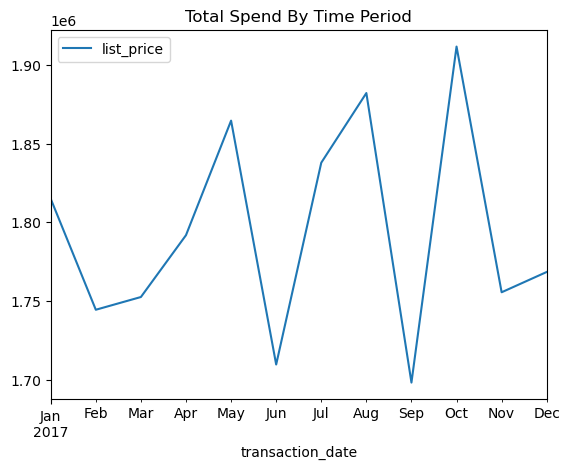

In [16]:
TestObject.plot("spend_by_period")
TestObject.spend_by_period()

,Total Count Of Active customer_id,Total Count Of New Joiner customer_id,Total Count Of Retained customer_id
transaction_date,,,
2017-01-01,1321,1321,0
2017-02-01,1258,794,464
2017-03-01,1277,490,787
2017-04-01,1284,341,943
2017-05-01,1281,214,1067
2017-06-01,1238,128,1110
2017-07-01,1327,83,1244
2017-08-01,1346,54,1292
2017-09-01,1240,25,1215


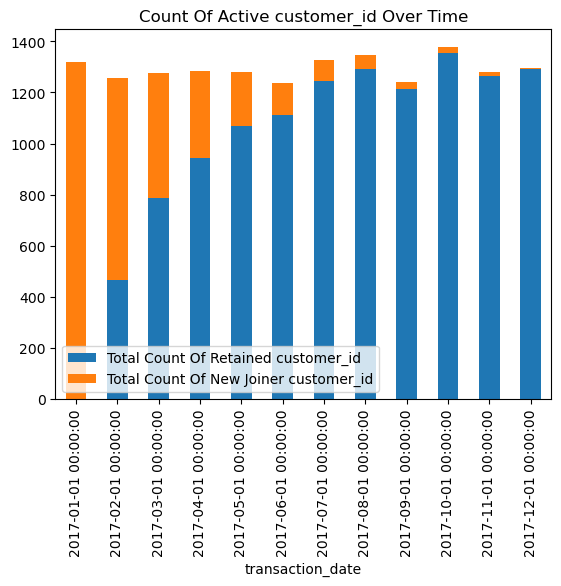

In [17]:
TestObject.plot("total_active_customers_by_period")
TestObject.total_active_customers_by_period()

Here we can ignore the first few periods as it is likely the dataset is just a continuation of previous year data so the "new" customers seen are not true new customers but just existing who haven't yet bought within the data sample period. However there is a trend that over time towards Q3/4 the no of new customers has reduced dramatically. 

Just for contrast, it is important to note that Time Granularity matters as the picture looks slightly different at a week by week basis

,Total Count Of Active customer_id,Total Count Of New Joiner customer_id,Total Count Of Retained customer_id
transaction_date,,,
2017-01-01,52,52.0,0.0
2017-01-08,357,355.0,2.0
2017-01-15,354,315.0,39.0
2017-01-22,361,294.0,67.0
2017-01-29,324,225.0,99.0
2017-02-05,382,242.0,140.0
2017-02-12,356,206.0,150.0
2017-02-19,385,211.0,174.0
2017-02-26,361,172.0,189.0


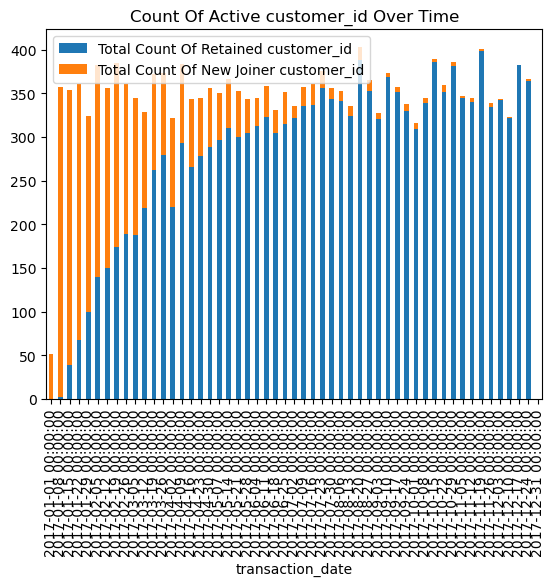

In [18]:
TestObjectByWeek=CustRetAnalysisObj(BikeTransactions,"transaction_id",
                  "transaction_id",
                  "customer_id",
                  "transaction_date",
                  "list_price",
                  "W")

TestObjectByWeek.plot("total_active_customers_by_period")
TestObjectByWeek.total_active_customers_by_period()

Within this Weekly time granularity, it can be seen that the no of new customers is about approx 5-10 customers each week

In [19]:
#For the rest of the demo, let's return to mth by mth granularity
TestObject.customer_by_earliest_and_latest_transaction()

,customer_id,CohortJoinPeriod,Last Recent Order Period
0,1,2017-01-01,2017-12-01
1,2,2017-05-01,2017-08-01
2,3,2017-02-01,2017-09-01
3,4,2017-04-01,2017-06-01
4,5,2017-03-01,2017-12-01
...,...,...,...
3487,3497,2017-09-01,2017-11-01
3488,3498,2017-02-01,2017-08-01
3489,3499,2017-01-01,2017-11-01
3490,3500,2017-01-01,2017-08-01


Rather than just looking at the numbers within the context of the no of New vs Retained, a more important metric is the rate at which customers are leaving. This is what a Cohort chart shows where customers are grouped by a certain criteria and tracked over time to see how often they continue to transact after their first transaction

# 6.Cohort Analysis

The problem with using the Active Customer over time view is that at any given period, there will be a mix of customers who started transacting at different points of time. 
The custom object has a helpful function that pulls the earliest and the latest transaction date for each individual customer (NB : But only at Time Granularity set of course so it will default to Month Start in this scenario)

In [20]:
CustomerEarliestLatestTransaction=TestObject.customer_by_earliest_and_latest_transaction()
CustomerEarliestLatestTransaction

,customer_id,CohortJoinPeriod,Last Recent Order Period
0,1,2017-01-01,2017-12-01
1,2,2017-05-01,2017-08-01
2,3,2017-02-01,2017-09-01
3,4,2017-04-01,2017-06-01
4,5,2017-03-01,2017-12-01
...,...,...,...
3487,3497,2017-09-01,2017-11-01
3488,3498,2017-02-01,2017-08-01
3489,3499,2017-01-01,2017-11-01
3490,3500,2017-01-01,2017-08-01


For example within the month of June 2017 , there were a total of 1238 customers who made transactions.

In [21]:
FebMonthActiveCustomers=X[X["transaction_date"].dt.month==6]
FebMonthActiveCustomers=FebMonthActiveCustomers.merge(CustomerEarliestLatestTransaction[["customer_id","CohortJoinPeriod"]], on=["customer_id"])
FebMonthActiveCustomers                                                                                         

,transaction_date,customer_id,list_price,transaction_id_x,transaction_id_y,CohortJoinPeriod
0,2017-06-01,1,642.70,1,1,2017-01-01
1,2017-06-01,2,752.64,1,1,2017-05-01
2,2017-06-01,4,478.16,1,1,2017-04-01
3,2017-06-01,10,1071.23,1,1,2017-06-01
4,2017-06-01,15,1311.44,1,1,2017-01-01
...,...,...,...,...,...,...
1233,2017-06-01,3491,642.70,1,1,2017-02-01
1234,2017-06-01,3492,1073.07,1,1,2017-06-01
1235,2017-06-01,3493,2388.92,2,2,2017-03-01
1236,2017-06-01,3498,1227.34,1,1,2017-02-01


These were in turn made up of 128 "new" customers who joined in that month but others who joined in the prior months of Jan-May 2017.

In [22]:
pd.DataFrame(FebMonthActiveCustomers["CohortJoinPeriod"].value_counts()).sort_index()

,count
CohortJoinPeriod,
2017-01-01,462
2017-02-01,277
2017-03-01,165
2017-04-01,119
2017-05-01,87
2017-06-01,128


The problem is this does not tell us about the churn across time and we need to pivot the data against the Cohort Join Period to "follow" the customers across time. This is what a Cohort Analysis does where each customer REGARDLESS of where we represent the transactions across the "Time Steps" after they joined (i.e Month 1, Month 2, Month 3 etc)

# 6.1 Cohort Retention By Join Period By Time-Step

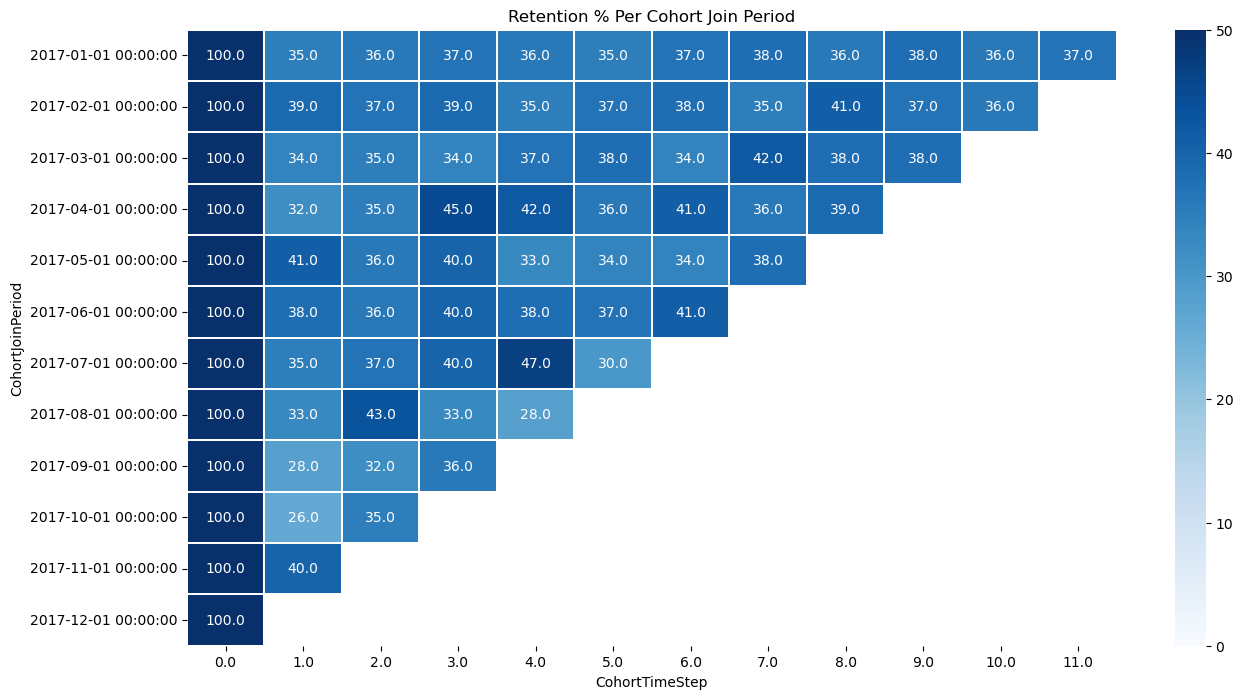

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
CohortJoinPeriod,,,,,,,,,,,,
2017-01-01,100.0,35.0,36.0,37.0,36.0,35.0,37.0,38.0,36.0,38.0,36.0,37.0
2017-02-01,100.0,39.0,37.0,39.0,35.0,37.0,38.0,35.0,41.0,37.0,36.0,NaN
2017-03-01,100.0,34.0,35.0,34.0,37.0,38.0,34.0,42.0,38.0,38.0,NaN,NaN
2017-04-01,100.0,32.0,35.0,45.0,42.0,36.0,41.0,36.0,39.0,NaN,NaN,NaN
2017-05-01,100.0,41.0,36.0,40.0,33.0,34.0,34.0,38.0,NaN,NaN,NaN,NaN
2017-06-01,100.0,38.0,36.0,40.0,38.0,37.0,41.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,35.0,37.0,40.0,47.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,33.0,43.0,33.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,28.0,32.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
TestObject.plot("cohort_by_acquisition_period")
TestObject.cohort_by_acquisition_period()


In [24]:
#the same function can be called with an additional argument of "abs" to show absolute count of customers rather than % change
TestObject.cohort_by_acquisition_period("abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
CohortJoinPeriod,,,,,,,,,,,,
2017-01-01,1321.0,464.0,477.0,483.0,480.0,462.0,493.0,502.0,479.0,501.0,471.0,494.0
2017-02-01,794.0,310.0,291.0,306.0,277.0,291.0,303.0,275.0,322.0,297.0,282.0,NaN
2017-03-01,490.0,169.0,171.0,165.0,179.0,184.0,168.0,206.0,184.0,186.0,NaN,NaN
2017-04-01,341.0,110.0,119.0,155.0,142.0,123.0,141.0,124.0,132.0,NaN,NaN,NaN
2017-05-01,214.0,87.0,77.0,86.0,70.0,73.0,72.0,81.0,NaN,NaN,NaN,NaN
2017-06-01,128.0,49.0,46.0,51.0,49.0,47.0,52.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,83.0,29.0,31.0,33.0,39.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,54.0,18.0,23.0,18.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,25.0,7.0,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The "spend" argument calculates the "absolute" total spend in dollar terms by the cohorts across time steps...

In [25]:
TestObject.cohort_by_acquisition_period("spend")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
CohortJoinPeriod,,,,,,,,,,,,
2017-01-01,1814943.0,667940.0,661292.0,670849.0,696117.0,645652.0,709522.0,676896.0,642150.0,701763.0,634554.0,625042.0
2017-02-01,1076597.0,420811.0,413377.0,440163.0,387135.0,391200.0,448014.0,364353.0,432586.0,412338.0,396376.0,NaN
2017-03-01,670516.0,248642.0,252938.0,220790.0,236745.0,253704.0,247126.0,295735.0,254353.0,259833.0,NaN,NaN
2017-04-01,458992.0,157254.0,163096.0,220498.0,196353.0,167062.0,189448.0,177204.0,199255.0,NaN,NaN,NaN
2017-05-01,318067.0,119162.0,105881.0,121977.0,91924.0,102182.0,96778.0,123994.0,NaN,NaN,NaN,NaN
2017-06-01,173950.0,71438.0,71919.0,83796.0,68672.0,65507.0,72159.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,102560.0,36399.0,42318.0,46860.0,50594.0,41452.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,76786.0,20733.0,35059.0,31104.0,20106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,38858.0,8278.0,6672.0,9296.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 6.2 Cohort Retention By Customer Attribute By Time-Step

Although cohort by joining period provides a useful starting point, it may be more meaningful to analyse the customer transactional behaviors by the demographic characteristics which is what the next function does

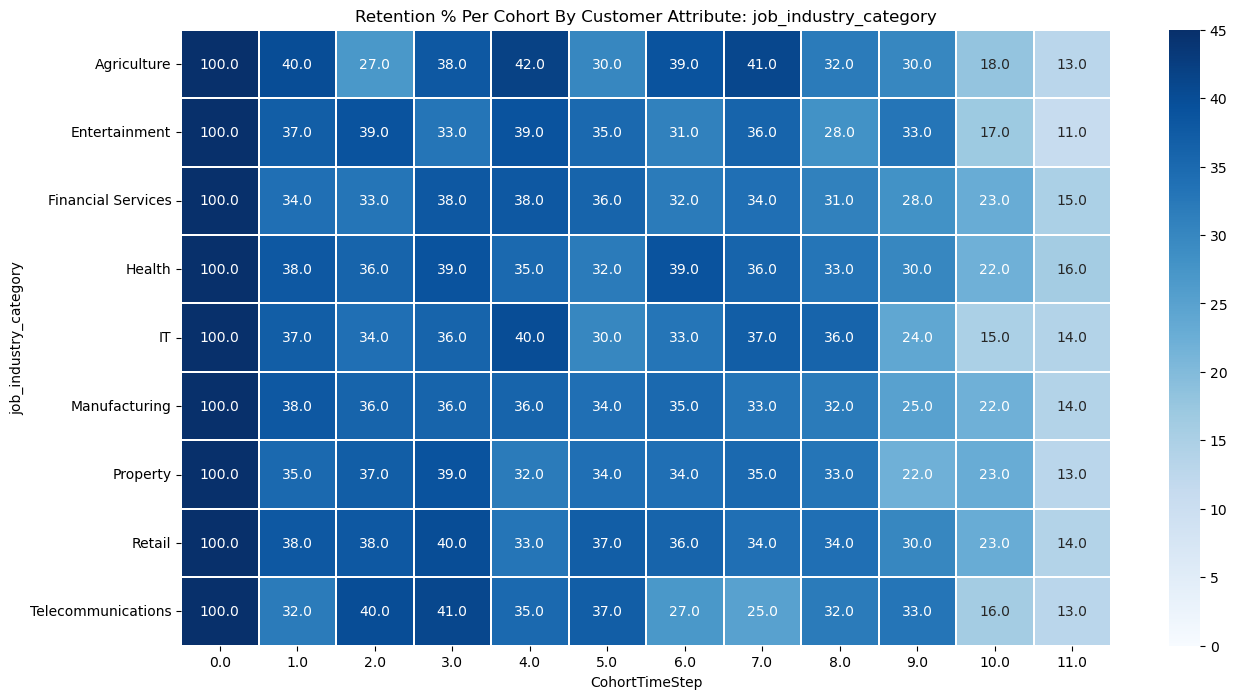

In [26]:
TestObject.plot("cohort_by_customer_attr",BikeCustomers,"job_industry_category")

In [27]:
TestObject.cohort_by_customer_attr(BikeCustomers,"job_industry_category")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
job_industry_category,,,,,,,,,,,,
Agriculture,100.0,40.0,27.0,38.0,42.0,30.0,39.0,41.0,32.0,30.0,18.0,13.0
Entertainment,100.0,37.0,39.0,33.0,39.0,35.0,31.0,36.0,28.0,33.0,17.0,11.0
Financial Services,100.0,34.0,33.0,38.0,38.0,36.0,32.0,34.0,31.0,28.0,23.0,15.0
Health,100.0,38.0,36.0,39.0,35.0,32.0,39.0,36.0,33.0,30.0,22.0,16.0
IT,100.0,37.0,34.0,36.0,40.0,30.0,33.0,37.0,36.0,24.0,15.0,14.0
Manufacturing,100.0,38.0,36.0,36.0,36.0,34.0,35.0,33.0,32.0,25.0,22.0,14.0
Property,100.0,35.0,37.0,39.0,32.0,34.0,34.0,35.0,33.0,22.0,23.0,13.0
Retail,100.0,38.0,38.0,40.0,33.0,37.0,36.0,34.0,34.0,30.0,23.0,14.0
Telecommunications,100.0,32.0,40.0,41.0,35.0,37.0,27.0,25.0,32.0,33.0,16.0,13.0


Similarly as per before with cohort by acquisition period, the same table can be generated with absolute counts rather than percentages by appending the "abs" term

In [28]:
TestObject.cohort_by_customer_attr(BikeCustomers,"job_industry_category","abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
job_industry_category,,,,,,,,,,,,
Agriculture,100.0,40.0,27.0,38.0,42.0,30.0,39.0,41.0,32.0,30.0,18.0,13.0
Entertainment,123.0,45.0,48.0,41.0,48.0,43.0,38.0,44.0,35.0,41.0,21.0,13.0
Financial Services,686.0,231.0,224.0,263.0,262.0,247.0,221.0,234.0,210.0,192.0,161.0,100.0
Health,532.0,200.0,193.0,206.0,184.0,171.0,210.0,190.0,178.0,158.0,118.0,84.0
IT,189.0,69.0,65.0,68.0,75.0,57.0,63.0,69.0,68.0,46.0,29.0,26.0
Manufacturing,703.0,270.0,256.0,254.0,251.0,236.0,243.0,233.0,226.0,179.0,152.0,98.0
Property,231.0,82.0,85.0,89.0,74.0,78.0,78.0,80.0,76.0,51.0,52.0,31.0
Retail,303.0,114.0,116.0,122.0,99.0,112.0,110.0,104.0,104.0,92.0,69.0,41.0
Telecommunications,63.0,20.0,25.0,26.0,22.0,23.0,17.0,16.0,20.0,21.0,10.0,8.0


# 6.3 Total Average Retention % By Time Step

Another useful overview is to view the aggregated behavior in a retention over time graph....

,Retained Customers By TimeStep,Retention Rate %
CohortTimeStep,,
0.0,3492.0,100.00
1.0,1255.0,35.94
2.0,1251.0,35.82
3.0,1306.0,37.40
4.0,1251.0,35.82
5.0,1205.0,34.51
6.0,1229.0,35.19
7.0,1188.0,34.02
8.0,1117.0,31.99


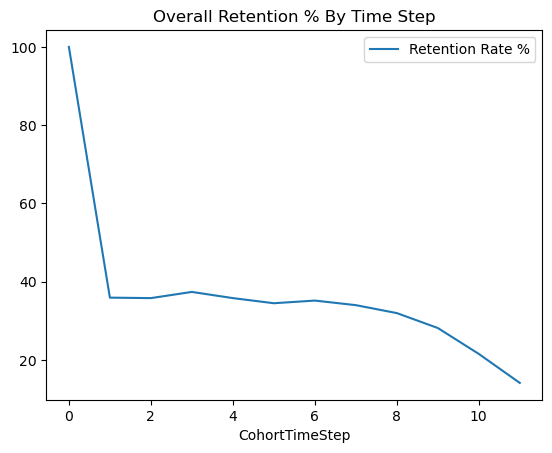

In [29]:
TestObject.plot("overall_retention_by_timestep")
TestObject.overall_retention_by_timestep()

# 6.4 Total No Of Customers By Cumulative Transaction Count

There is also a function that returns the count of customers by total transaction count and no of customers who have at least X transactions 

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,85,3492
2,300,3407
3,627,3107
4,840,2480
5,762,1640
6,515,878
7,242,363
8,89,121
9,27,32


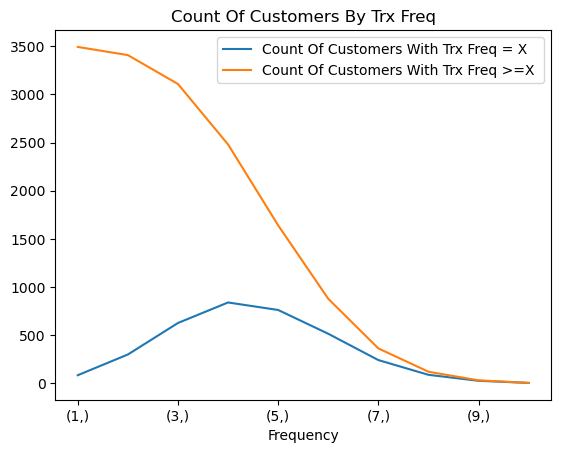

In [30]:
TestObject.plot("count_of_customers_by_min_trx_count")
TestObject.count_of_customers_by_min_trx_count()

# 6.5 Duration Between Transactions

,Mean Time Between Transactions In Months,10th Percentile In Months,Median In Months,90th Percentile In Months
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,2.55,0.98,1.93,5.02
3,2.40,0.98,2.00,5.02
4,2.19,0.98,2.00,4.03
5,1.90,0.98,1.02,3.02
6,1.69,0.98,1.02,3.02
7,1.54,0.98,1.02,2.98
8,1.31,0.98,1.02,2.00
9,1.37,0.98,1.00,2.00


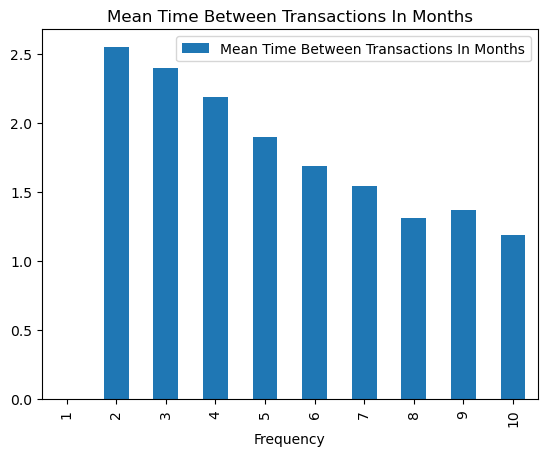

In [31]:
#This function provides the estimate of time between the transactions 
TestObject.plot("time_between_transactions")
TestObject.time_between_transactions()

# 6.6 Cohort Retention By Time-Step Using A Max Inactive Period Assumption

From the earlier Cohort Retention % by Join Period , it is clear that the steep drop in retention (the elbow) happens within the first month itself. Given that the data-set is limited (only 1 year) , a different approach to estimating retention that is less conservative is to focus on the last transaction only and assume that beyond a certain X threshold, the customer will have churned (ie max period of inactivity before churn estimate)

In [32]:
MaxInactivePeriod=15 #max period of inactivity since the latest/most recent transaction before customer is considered as "churned"

In [33]:
#This gives the Expiry Period upon which the above is built 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"ExpiryDateByCustomer")

,customer_id,CohortJoinPeriod,Last Recent Order Period,Customer Expiry Period
0,1,2017-01-01,2017-12-01,2017-12-16
1,2,2017-05-01,2017-08-01,2017-08-16
2,3,2017-02-01,2017-09-01,2017-09-16
3,4,2017-04-01,2017-06-01,2017-06-16
4,5,2017-03-01,2017-12-01,2017-12-16
...,...,...,...,...
3487,3497,2017-09-01,2017-11-01,2017-11-16
3488,3498,2017-02-01,2017-08-01,2017-08-16
3489,3499,2017-01-01,2017-11-01,2017-11-16
3490,3500,2017-01-01,2017-08-01,2017-08-16


In [34]:
# IMPORTANT - this duration in Days will be limited by the granularity selected.... 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod)

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,10,11
CohortJoinPeriod,,,,,,,,,,,,
2017-01-01,100.0,100.0,99.0,99.0,98.0,97.0,94.0,90.0,84.0,75.0,60.0,37.0
2017-02-01,100.0,100.0,99.0,97.0,96.0,95.0,92.0,86.0,76.0,60.0,36.0,NaN
2017-03-01,100.0,99.0,98.0,97.0,94.0,90.0,85.0,78.0,61.0,38.0,NaN,NaN
2017-04-01,100.0,99.0,99.0,96.0,93.0,84.0,76.0,60.0,39.0,NaN,NaN,NaN
2017-05-01,100.0,96.0,94.0,90.0,82.0,72.0,58.0,38.0,NaN,NaN,NaN,NaN
2017-06-01,100.0,95.0,92.0,88.0,80.0,61.0,41.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,90.0,87.0,80.0,65.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,80.0,74.0,54.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,60.0,52.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


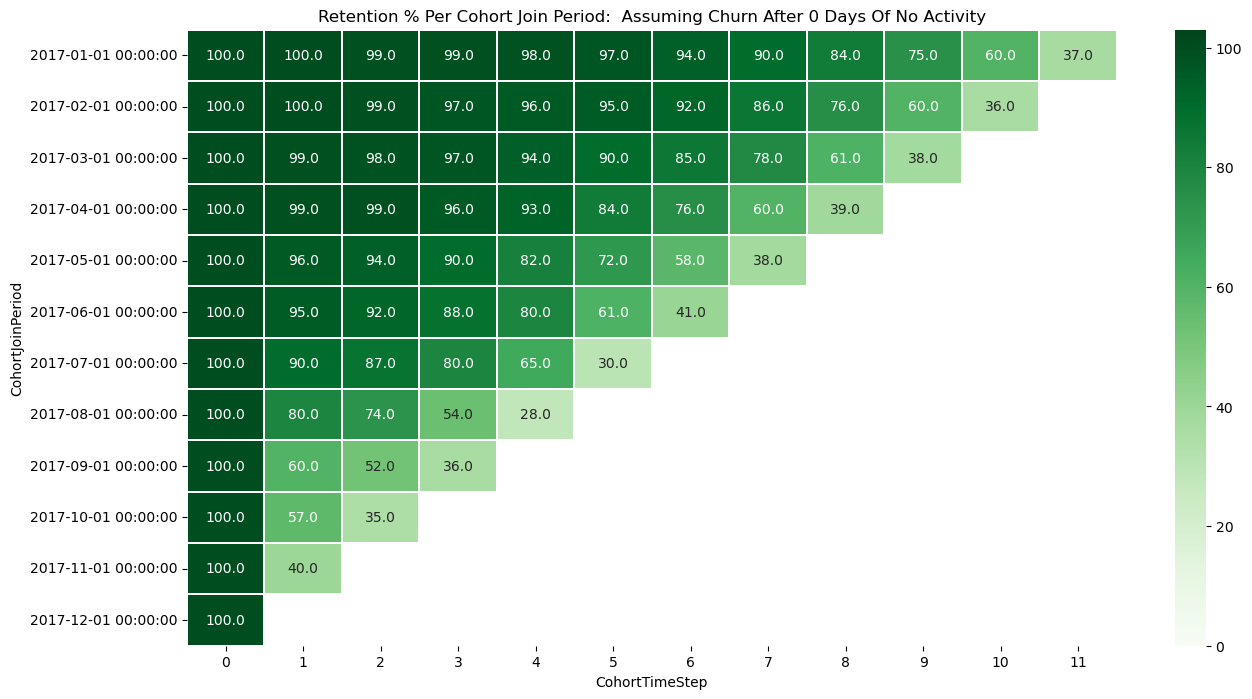

In [35]:
TestObject.plot("cohort_by_acquisition_period_by_inactive_period",MaxInactivePeriod)

In [36]:
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"abs")

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,10,11
CohortJoinPeriod,,,,,,,,,,,,
2017-01-01,1321.0,1317.0,1313.0,1306.0,1297.0,1276.0,1245.0,1191.0,1112.0,997.0,794.0,494.0
2017-02-01,794.0,791.0,784.0,774.0,766.0,753.0,729.0,682.0,604.0,473.0,282.0,NaN
2017-03-01,490.0,483.0,478.0,474.0,461.0,441.0,418.0,380.0,297.0,186.0,NaN,NaN
2017-04-01,341.0,337.0,336.0,329.0,316.0,286.0,260.0,205.0,132.0,NaN,NaN,NaN
2017-05-01,214.0,206.0,201.0,192.0,176.0,155.0,125.0,81.0,NaN,NaN,NaN,NaN
2017-06-01,128.0,121.0,118.0,112.0,102.0,78.0,52.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,83.0,75.0,72.0,66.0,54.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,54.0,43.0,40.0,29.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,25.0,15.0,13.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some judgement must be applied in interpreting the output above but it provides an alternative means to estimating retention

# 7. Recency, Frequency & Monetary RFM Analysis

Ultimately though ,the same data can be reflected in terms of Recency , Frequency and Monetary Value RFM Analysis but this works best with more granularity timescales (days vs mths)

In [37]:
#RFM typically works best with day level granularity

TestObjectInDays=CustRetAnalysisObj(BikeTransactions,"transaction_id",
                  "transaction_id",
                  "customer_id",
                  "transaction_date",
                  "list_price",
                  "d")

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,61,3492
2,210,3431
3,411,3221
4,531,2810
5,613,2279
6,575,1666
7,432,1091
8,291,659
9,188,368


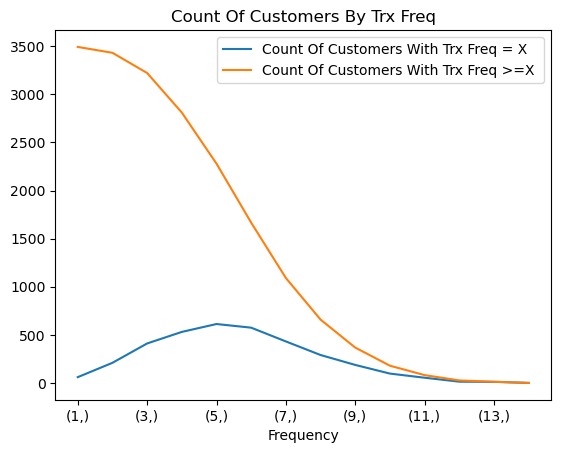

In [38]:
TestObjectInDays.plot("count_of_customers_by_min_trx_count")
TestObjectInDays.count_of_customers_by_min_trx_count()

,Mean Time Between Transactions In Days,10th Percentile In Days,Median In Days,90th Percentile In Days
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,62.26,7.0,45.0,144.0
3,58.94,8.0,45.0,134.0
4,53.79,6.0,39.0,122.0
5,49.25,6.0,36.0,112.2
6,44.24,5.0,32.0,100.0
7,39.56,5.0,30.0,88.0
8,36.47,4.0,28.0,79.0
9,33.79,4.0,27.0,76.0


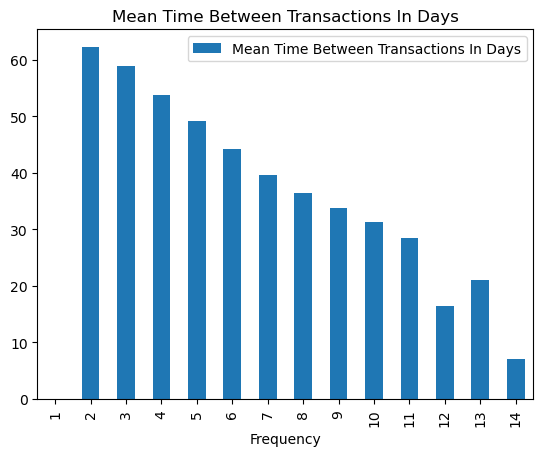

In [39]:
TestObjectInDays.plot("time_between_transactions")
TestObjectInDays.time_between_transactions()

In [40]:
RFM_table=TestObjectInDays.create_RFM_Table()
RFM_table

,customer_id,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Days
2471,2476,14,13,305.0,319.0,2017-02-14,2017-12-16,14578.69,1661.92,24.54,993.60
2459,2464,13,12,308.0,310.0,2017-02-23,2017-12-28,14574.06,958.74,25.83,1134.61
1299,1302,13,12,325.0,354.0,2017-01-10,2017-12-01,17035.83,1720.70,29.50,1276.26
2543,2548,13,12,357.0,360.0,2017-01-04,2017-12-27,14027.08,1061.56,30.00,1080.46
3317,3326,13,12,325.0,354.0,2017-01-10,2017-12-01,14078.19,1483.20,29.50,1049.58
...,...,...,...,...,...,...,...,...,...,...,...
2389,2394,1,0,0.0,90.0,2017-10-01,2017-10-01,980.37,980.37,0.00,0.00
3270,3279,1,0,0.0,297.0,2017-03-08,2017-03-08,1071.23,1071.23,0.00,0.00
2743,2749,1,0,0.0,34.0,2017-11-26,2017-11-26,1061.56,1061.56,0.00,0.00
2390,2395,1,0,0.0,62.0,2017-10-29,2017-10-29,230.91,230.91,0.00,0.00


,Average
Recency In Days,237.37
Frequency,5.53
Average Time Between Orders In Days,83.50
Average Monetary Value Per Days,1099.65


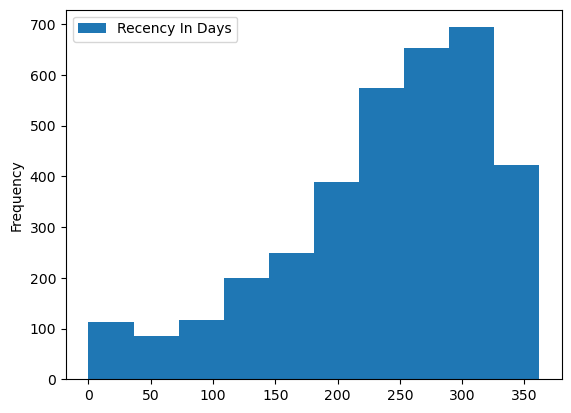

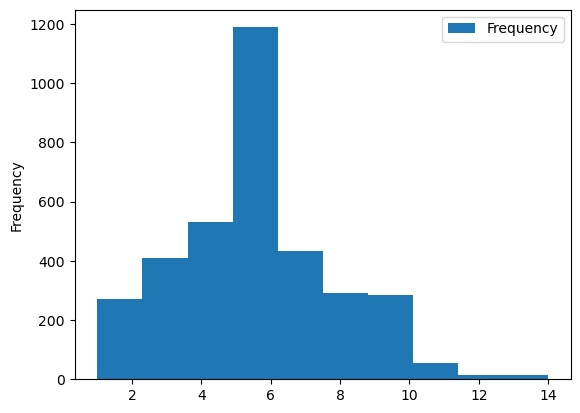

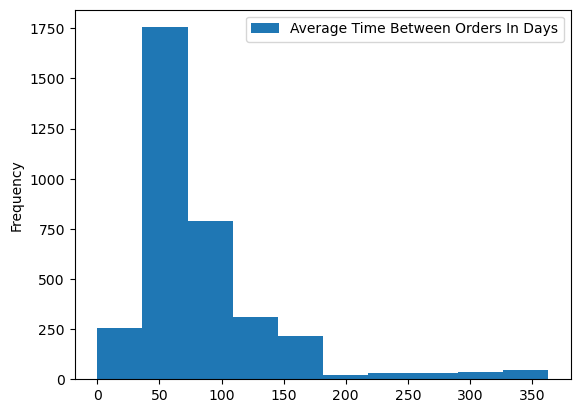

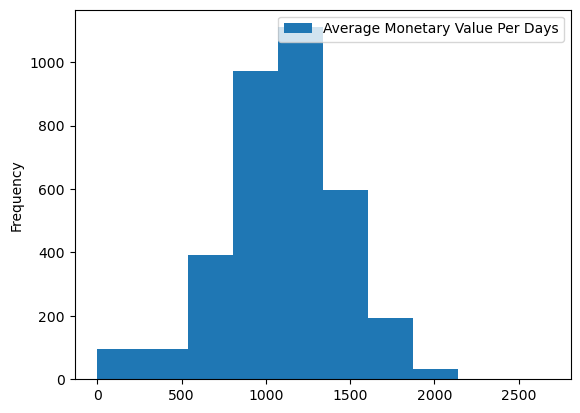

In [41]:
TestObjectInDays.plot("RFM_summary")